## Process DSF data in NEW way

We want to compute the `Dynamical Structure Factor`, which is given by

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \hat{S}_{\vec{q}}^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \delta(\omega - (E_n^X - E_0)) $$

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \hat{S}_{\vec{q}}^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

Where

$$ \hat{S}_{\vec{q}}^{\alpha} = \frac{1}{\sqrt{L}} \sum_{i = 0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \hat{S}_i^{\alpha} $$

So, we can rewrite the DSF as:
$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \left\langle \Psi_n^X \left| \frac{1}{\sqrt{L}} \sum_{i=0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

$$ S_{\vec{q}}(w) = \sum_{n=1}^{nev} \left| \frac{1}{\sqrt{L}} \sum_{i=0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \left\langle \Psi_n^X \left| \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle \right| ^2 \frac{1}{\pi} \frac{\epsilon^2}{(\omega - (E_n^X - E_0))^2 + \epsilon^2} $$

From the code we obtain a file with two columns: 
1. the first one, has the values of $ \Delta_n = E_n^X -E_0 $
2. the second one, has the values of the coefficient $ \left\langle \Psi_n^X \left| \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle $

In [1]:
import numpy as np
import cmath as m
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import axes3d
from matplotlib.collections import PolyCollection
%matplotlib notebook

### Parameters

In [2]:
# Lattice

dim      = 2           # Dimension of the lattice
nspins   = 16          # Number of spins in the system

if dim == 1:
    Lx   = 1            # Number of spins in the system in x direction
    Ly   = nspins       # Number of spins in the system in y direction
else:
    Lx   = 4
    Ly   = 4
    
r_idx    = [i for i in range(nspins)]
r_idxX   = [i//Ly for i in r_idx]
r_idxY   = [i%Ly for i in r_idx]

print("r:", r_idx)
print("rx:", r_idxX)
print("ry:", r_idxY)
    
rep      = 1000         # Disorder realizations
nev      = 200          # Number of excited states used

r: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
rx: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
ry: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]


In [3]:
# Reciprocal lattice

nQ       = nspins            # Number of q values to analyse
pi       = np.arccos(-1)
q_idx    = [i for i in range(nQ)]
q_idxX   = [(i//Ly)*2*pi/Lx for i in q_idx]
q_idxY   = [(i%Ly)*2*pi/Ly for i in q_idx]

q_X   = [(i//Ly) for i in q_idx]
q_Y   = [(i%Ly) for i in q_idx]

print("q:", q_idx)
print("qx:", q_idxX)
print("qy:", q_idxY)
print("qx:", q_X)
print("qy:", q_Y)

q: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
qx: [0.0, 0.0, 0.0, 0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 4.71238898038469, 4.71238898038469, 4.71238898038469, 4.71238898038469]
qy: [0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469]
qx: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]
qy: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]


In [4]:
# Hamiltonian parameters

J1       = 1.0          # Nearest neighbours coupling
D1       = 1.0          # Nearest neighbours anisotropy
J2       = 0.5          # Next-nearest neighbours coupling
D2       = 0.5          # Next-nearest neighbours anisotropy

In [5]:
# Frequency parametes

nW       = 5001         # Number of frequency values to plot
w_min    = 0            # Minimum value of frequency to plot
w_max    = 5            # Maximum value of frequency to plot
epsilon  = 1.0/nspins   # Constant to compute the Dirac delta function

In [6]:
# Files

read = True

#path2INdata  ='/home/ale/mhpcProject/QuantumMagnetsLSSimulation/c++/build_tests/'
path2INdata  = '/home/ale/square2D/16nnn0_5/'
path2OUTdata = '/home/ale/square2D/16nnn0_5/'

### Prepare data

#### 1a. Read data from files

In [7]:
# DeltaEn and factorN have the values of (En-E0) and the preceeding factor of the DSF
DeltaEn = np.empty((nev,rep))
factorNSPIN = np.empty((nev*nspins,rep))

# Loop over disorder realizations
for dis_rep in range(rep):
    
    # Loop over excited states
    with open(path2INdata + 'dsf_d' + str(dis_rep) + '_ns' + str(nspins) + '_nev' + str(nev) + '.dat') as INfile:
    #with open(path2INdata + 'dsf_NODISORDER' + '_ns' + str(nspins) + '_nev' + str(nev) + '.dat') as INfile:
        array = np.genfromtxt(INfile)
        tmp_DeltaEn, tmp_factorN = array.T
            
    
    DeltaEn[:,dis_rep] = tmp_DeltaEn[0:nev]
    factorNSPIN[:,dis_rep] = tmp_factorN

In [8]:
delta_w  = (w_max - w_min)/(nW - 1)
w  = np.linspace(w_min,w_max,nW)
tmp_Sw = np.zeros((rep,nQ,nW))
Sw = np.zeros((nQ,nW))

# Loop over q values
e2 = epsilon*epsilon

# Funtion to compute the Dirac delta
pi     = np.arccos(-1)
inv_pi = 1.0/pi

def DiracDelta(w,deltaEn,e2):
    return inv_pi*e2/(e2 + (w-deltaEn)*(w-deltaEn))

#### 1b. Sum over lattice sites

So, basically, one has to do the part:

$$ \frac{1}{\sqrt{L}} \sum_{i=0}^{L-1} e^{i \vec{q} \cdot \vec{r}_i} \left\langle \Psi_n^X \left| \hat{S}_i^{\alpha} \right| \Psi_0 \right\rangle $$

In [9]:
if read == False:
    
    # Compute the exponential coefficient

    expCoeff = np.empty((nQ,nspins),dtype=np.complex)

    for q in range(nQ):
        for spin in range(nspins):
            coeff = q_idxX[q]*r_idxX[spin] + q_idxY[q]*r_idxY[spin]
            expCoeff[q,spin] = m.exp(1j*coeff)

In [10]:
if read == False:
    # Sum over the spins

    print(factorNSPIN.shape)

    factorN_cplx = np.zeros((nQ,rep,nev),dtype=np.complex)

    print(factorN_cplx.shape)

    for q in range(nQ):
        for n in range(nev):
            for i in range(nspins):
                offset = i * nev
                factorN_cplx[q,:,n] = factorN_cplx[q,:,n] + expCoeff[q,i]*factorNSPIN[n+offset,:]

    factorN = np.empty((nQ,rep,nev))
    factorN[:,:,:] = abs(factorN_cplx[:,:,:])**2/nspins

In [11]:
if read == False:
    for dis_rep in range(rep):

        # Compute the values of DeltaDirac to make the next step faster
        deltad = np.zeros((nW,nev))
        for n in range(nev):
            for wi in range(nW):
                deltad[wi,n] = DiracDelta(w[wi],DeltaEn[n,dis_rep],e2)

        for q in range(nQ):                
            for wi in range(nW):
                #mid_array = factorN[q,dis_rep,:]*DiracDelta(w[wi],DeltaEn[:,dis_rep],e2)
                mid_array = factorN[q,dis_rep,:]*deltad[wi,:]
                tmp_Sw[dis_rep,q,wi] = np.sum(mid_array)

    # Save the values of Sq(w) for all the disorder realizations
    for dis_rep in range(rep):
        header = "disorder realization:" + str(dis_rep) + "\n"+"        w                 Sw"
        np.savetxt(path2OUTdata + '/Sq/Sq_' + str(dis_rep) + '.csv', np.c_[w,tmp_Sw[dis_rep,:,:].T], header=header, fmt='%16.13e', delimiter=' ',)

In [12]:
if read == False:
    # Compute average over disorder realizations
    Sw = np.sum(tmp_Sw, axis=0)
    Sw *= 2*pi
    Sw /= rep
    Sw = Sw.T

#### 3. Write in file

In [13]:
if read == False:
    header = "        w                 Sw"
    np.savetxt(path2OUTdata + 'Sq.csv', np.c_[w,Sw], header=header, fmt='%16.13e', delimiter=' ',)      

#### 3. Read Sq(w) from file

In [14]:
if read == True:
    with open(path2INdata + 'Sq.csv') as csvfile:
            tmp_read_Sw = np.genfromtxt(csvfile)
    Sw = tmp_read_Sw[:,1:]

    for dis_rep in range(rep):
        with open(path2INdata + 'Sq/Sq_' + str(dis_rep) + '.csv') as dis_csvfile:
            tmp_read_Sw_dis = np.genfromtxt(dis_csvfile)
        tmp_Sw[dis_rep,:,:] = tmp_read_Sw_dis[:,1:].T

### Check convergibility

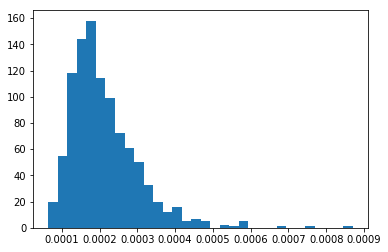

In [15]:
# One should obtain a Gaussian profile when doing a histogram of the Sq(w) values, for a particular q and w values

hist, bins, patches = plt.hist(tmp_Sw[:,1,1000], bins=32)
plt.show()

(5001,) (5001,)


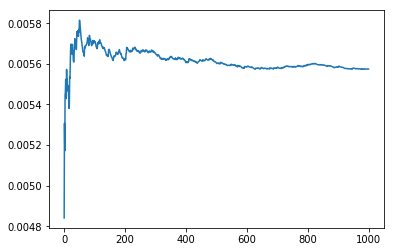

In [16]:
# For a particular w and q values, plot Sq(w) values for different amounts of disorder realizations averaged
check_Sw = np.zeros((rep,nQ,nW))
for dis_rep in range(rep):
    check_Sw[dis_rep,:,:] = check_Sw[dis_rep-1,:,:] + tmp_Sw[dis_rep,:,:]

e_msg = "Steps do not match"
for wi in range(nW):
    assert (check_Sw[1,10,wi]-tmp_Sw[0,10,wi]-tmp_Sw[1,10,wi])<1e-15, e_msg
    assert (check_Sw[999,10,wi]*2*pi/rep-Sw[wi,10])<1e-14, e_msg

check_Sw *= 2*pi

print(check_Sw[999,10,:].shape, Sw[:,10].shape)
for dis_rep in range(1,rep):
    check_Sw[dis_rep,:,:] /= (dis_rep+1)

for wi in range(nW):
    assert (check_Sw[999,10,wi]-Sw[wi,10])<1e-14, e_msg
    
# Plot the cummulative values
d = np.linspace(0,rep-1,rep)
plt.plot(d,check_Sw[:,10,2345])

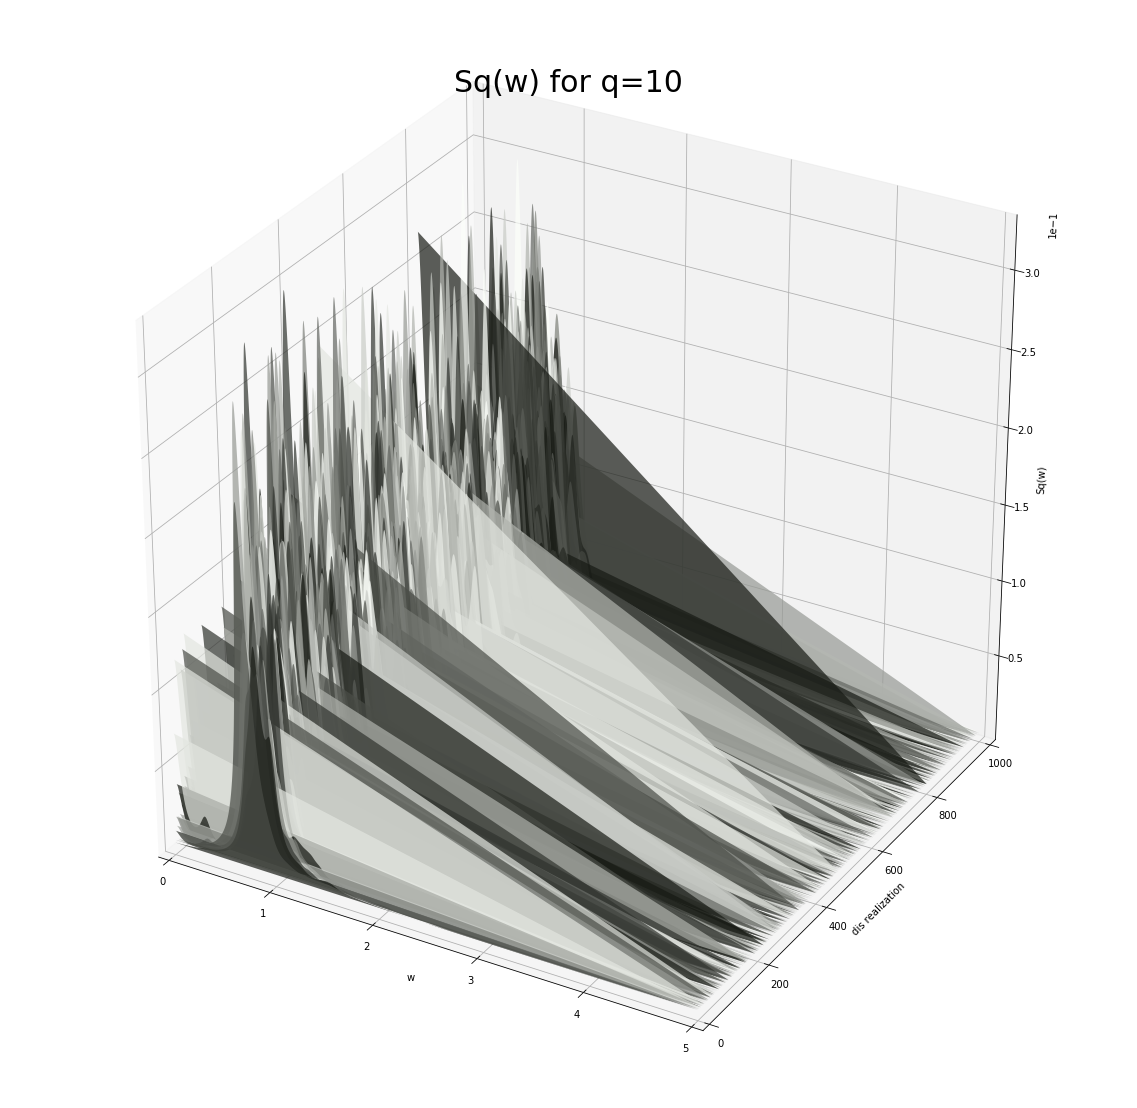

In [17]:
# Maximum value over all Sq(w)
max = 0
for dis_rep in range(rep):
    tmp_max = tmp_Sw[:,10,:].max()
    if tmp_max >= max:
        max = tmp_max
        
# disorder values for plotting
d = np.linspace(0,rep-1,rep)

# Prepare data for 3D plot
verts = []
for dis_rep in range(rep):
    verts.append(list(zip(w,tmp_Sw[dis_rep,10,:])))

# Set colors
fc = []
for dis_rep in range(rep):
    fc.append(((dis_rep%10)*0.1+0.09, (dis_rep%10)*0.1+0.1, (dis_rep%10)*0.1+0.08))

# Define the 3D plot
poly = PolyCollection(verts, facecolors = fc)
poly.set_alpha(0.7)

fig2 = plt.figure(figsize=(20,20))
ax2  = fig2.add_subplot(111, projection='3d')
ax2.add_collection3d(poly, zs=d, zdir='y')

# Plot details
ax2.set_title('Sq(w) for q=10', fontsize=30)
ax2.ticklabel_format(axis='z', style='sci', scilimits=(0,0))

ax2.set_xlim3d(w.min(), w.max())
ax2.set_xlabel('w')
ax2.set_ylim3d(0,rep)
ax2.set_ylabel('dis realization')
#ax2.set_yticks(np.arange(0,rep,1))
ax2.set_zlim3d(tmp_Sw[:,10,:].min(), max)
ax2.set_zlabel('Sq(w)')

plt.show()

### Plot

#### 1. Plot for every q separately

4 4


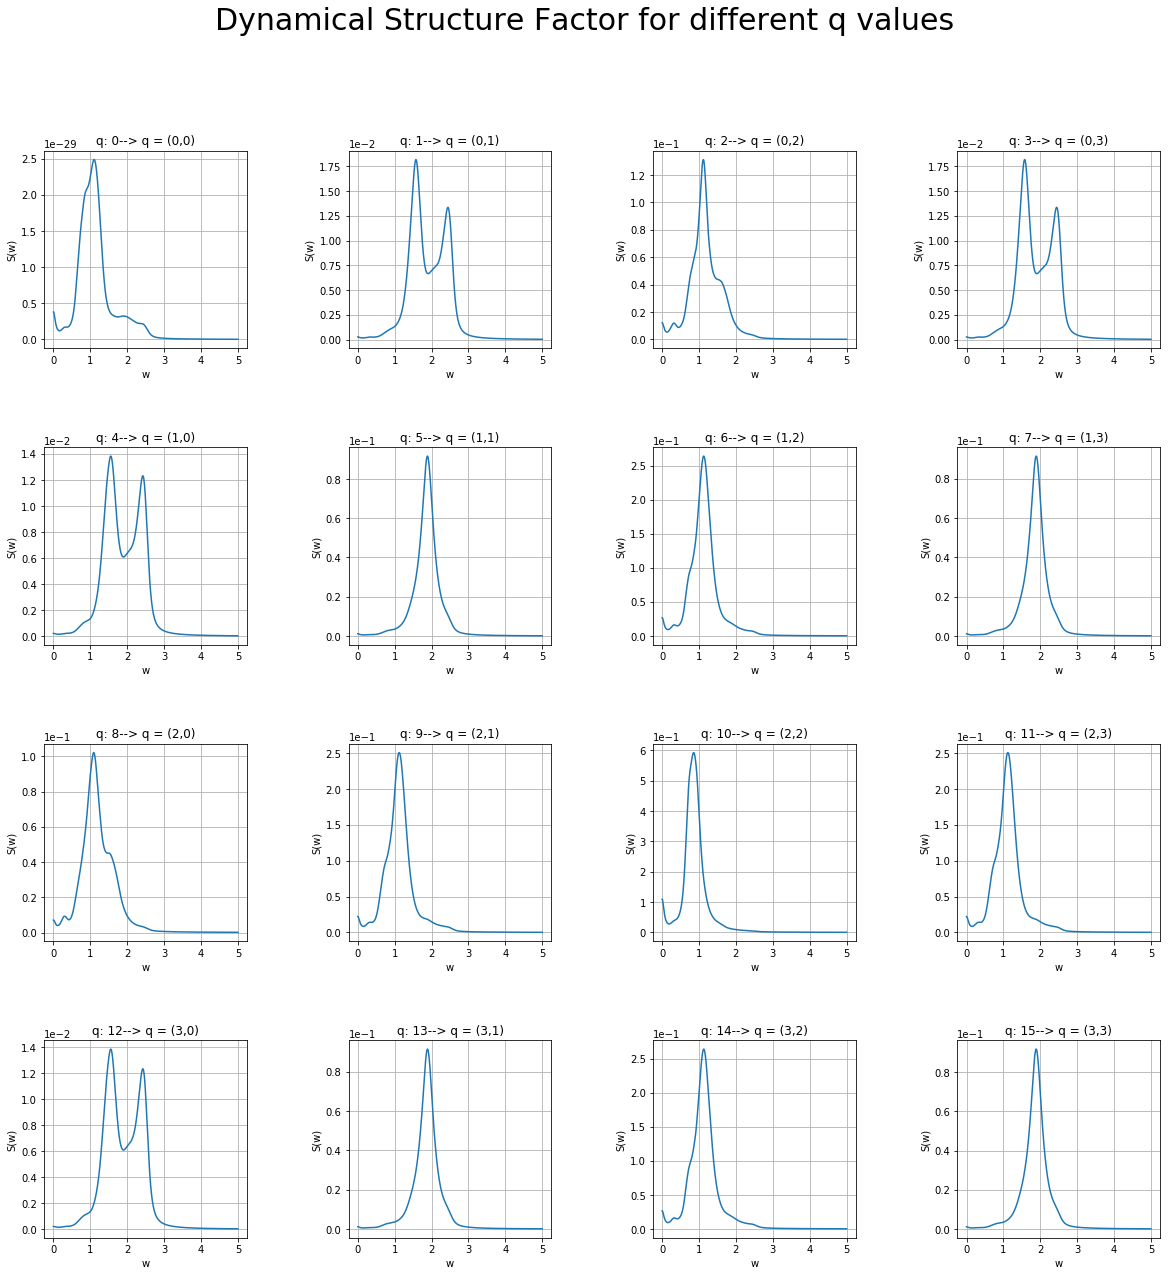

In [18]:
# Plot 1D chain lattices
subsX = nQ//4
subsY = 4

q_idxX_labl   = [(i//Ly) for i in q_idx]
q_idxY_labl   = [(i%Ly) for i in q_idx]

print(subsX, subsY)

fig, ax = plt.subplots(subsX, subsY, gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,20))
fig.suptitle("Dynamical Structure Factor for different q values", fontsize=30)


for i in range(subsX):
    for j in range(subsY):
        qij = i*subsY + j
        #print(qij,q_idx[qij])
        if qij >= nQ:
            break
        ax[i,j].set_title('q: ' + str(q_idx[qij]) + '--> q = (' + str(q_X[qij]) + ',' + str(q_Y[qij]) + ')')
        ax[i,j].set_xlabel('w')
        ax[i,j].set_ylabel('S(w)')
        ax[i,j].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax[i,j].grid()
        ax[i,j].plot(w,Sw[:,qij])

In [19]:
if dim == 2 and nspins == 32:
    fig3, ax3 = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))

    ax3[0].set_title('S(w) --> LARGER peak')
    ax3[0].set_xlabel('w')
    ax3[0].set_ylabel('S(w)')
    ax3[0].grid(which='both')
    ax3[0].plot(w, Sw[:,20])
    
    ax3[1].set_title('S(w) --> LARGER peak -- ZOOM IN')
    ax3[1].set_xlabel('w')
    ax3[1].set_ylabel('S(w)')
    ax3[1].grid(which='both')
    ax3[1].plot(w[1000:2000], Sw[1000:2000,20])

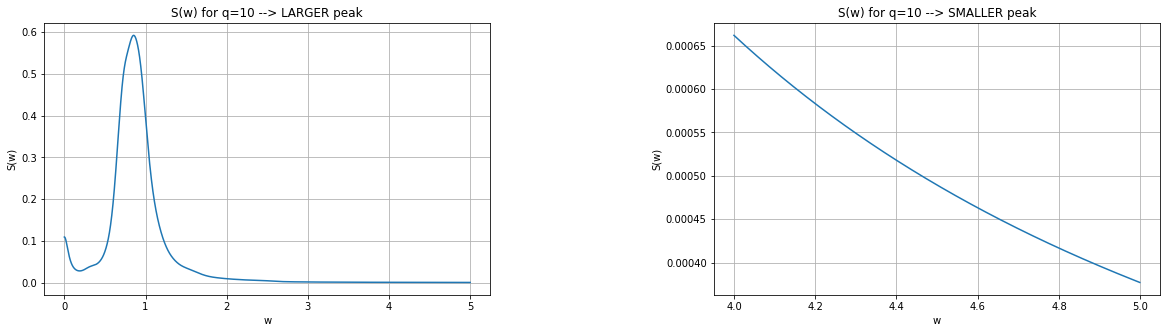

In [20]:
if dim == 2 and nspins == 16:
    fig3, ax3 = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))

    ax3[0].set_title('S(w) for q=10 --> LARGER peak')
    ax3[0].set_xlabel('w')
    ax3[0].set_ylabel('S(w)')
    ax3[0].grid()
    ax3[0].plot(w, Sw[:,10])

    ax3[1].set_title('S(w) for q=10 --> SMALLER peak')
    ax3[1].set_xlabel('w')
    ax3[1].set_ylabel('S(w)')
    ax3[1].grid()
    ax3[1].plot(w[4000:5000],Sw[4000:5000,10])

In [21]:
if dim == 2 and nspins == 16:
    # For (pi,pi) --> q=10 check the ratio between peaks
    max1 = np.argmax(Sw,axis=0)[10]
    max2 = np.argpartition(Sw[4000:5000,10],-1)[-1:]
    
    ratio = Sw[max1,10]/Sw[4000+max2[0],10]
    print('Ratio between larget peak and smaller one:', ratio)
    print('Approx ratio from literature (Chen,Schuttler PhysRevB1989):', 15.4/0.174)
    #print(max1, max2)
    #print(Sw[579,10])
    #print(Sw[4000+max2[0],10])

Ratio between larget peak and smaller one: 894.5465457956732
Approx ratio from literature (Chen,Schuttler PhysRevB1989): 88.50574712643679


#### 2. Plot all q values together

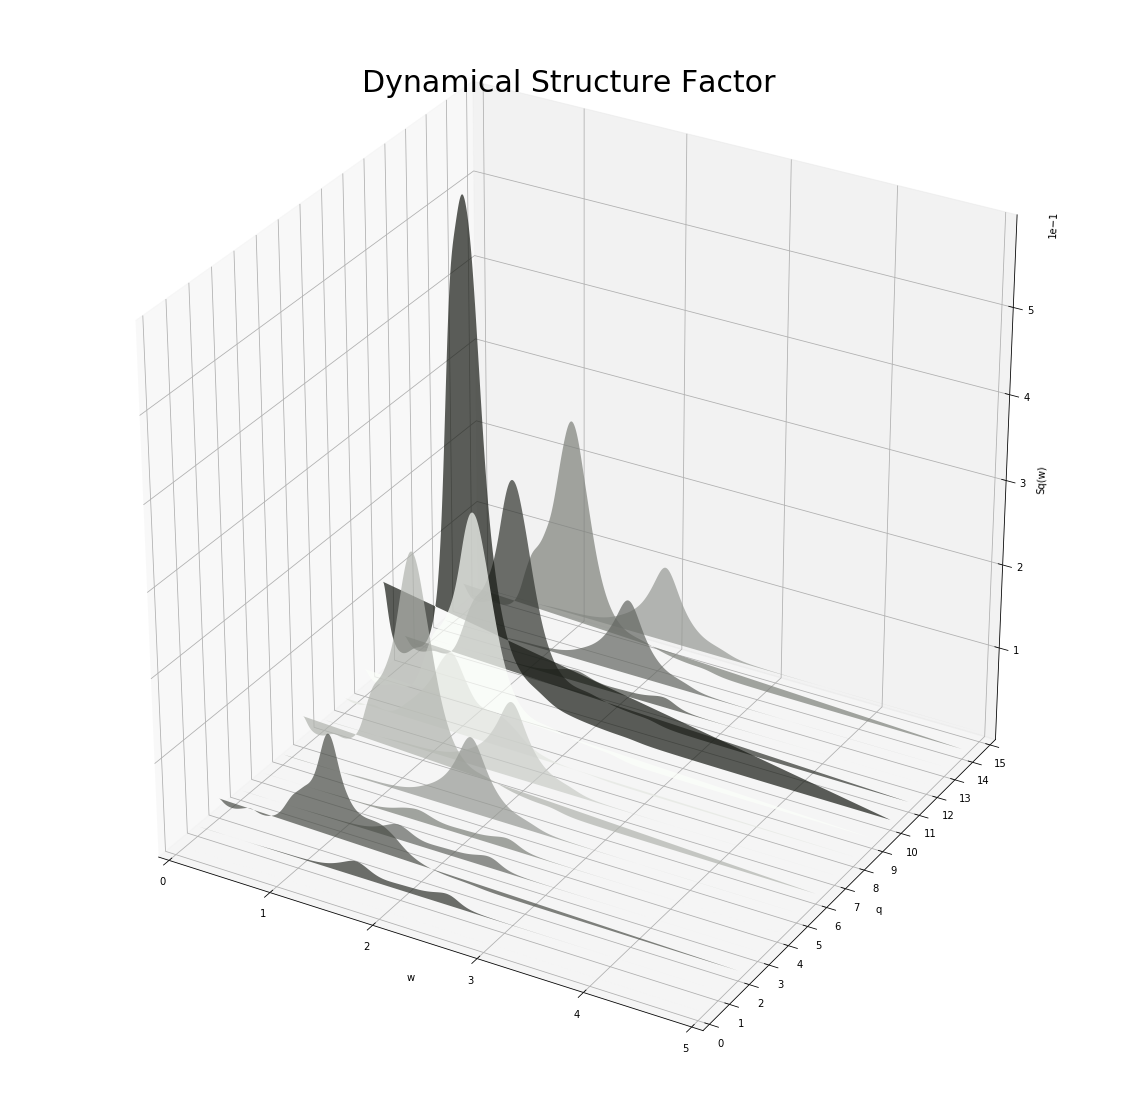

In [22]:
# Maximum value over all Sq(w)
max = 0
for qi in range(nQ):
    tmp_max = Sw[:,qi].max()
    if tmp_max >= max:
        max = tmp_max

# q values for plotting
q = np.linspace(0,nQ-1,nQ)

# Prepare data for 3D plot
verts = []
for qi in range(nQ):
    verts.append(list(zip(w,Sw[:,qi])))

# Set colors
fc = []
for qi in range(nQ):
    fc.append(((qi%10)*0.1+0.09, (qi%10)*0.1+0.1, (qi%10)*0.1+0.08))

# Define the 3D plot
poly = PolyCollection(verts, facecolors = fc)
poly.set_alpha(0.7)

fig2 = plt.figure(figsize=(20,20))
ax2  = fig2.add_subplot(111, projection='3d')
ax2.add_collection3d(poly, zs=q, zdir='y')

# Plot details
ax2.set_title('Dynamical Structure Factor', fontsize=30)
ax2.ticklabel_format(axis='z', style='sci', scilimits=(0,0))

ax2.set_xlim3d(w.min(), w.max())
ax2.set_xlabel('w')
ax2.set_ylim3d(q.min(), q.max())
ax2.set_ylabel('q')
ax2.set_yticks(np.arange(0,nQ,1))
ax2.set_zlim3d(Sw[:,2].min(), max)
ax2.set_zlabel('Sq(w)')

plt.show()

### Checks

##### 1. Sum rule: $ \sum_{\vec{q}} \int \frac{d\omega}{2\pi} S^{\gamma}_{\vec{q}}(\omega) = \frac{1}{4} 
\rightarrow 
\frac{\Delta\omega}{2\pi} \sum_{\vec{q}} \sum_i^{nW} S^{\gamma}_{\vec{q}}(\omega_i) = \frac{1}{4}$

In [23]:
sum_rule = np.sum(Sw) * delta_w / (2*pi)
e_msg = "Sum rule does not match: sum_rule = " + str(sum_rule)
assert abs(sum_rule - 0.25)<0.01, e_msg
print('Sum rule: ', sum_rule)

AssertionError: Sum rule does not match: sum_rule = 0.22028423582789775

#### 2. Dispersion relationship (ONLY FOR 1D)

In [ ]:
if dim == 1:
    # Get the positions of the highest peak for each q
    disp_w = np.argmax(Sw,axis=0)

    disp_fig, disp_ax = plt.subplots()

    # Plot dispersion along y axis
    #x0 = 2
    #q_y = np.zeros((Ly))
    #for i in range(Ly):
    #q_y[i] = i + x0 * Lx
    #qy = q_y.astype(int)
    #print(qy)

    disp_ax.set_title('Dispersion w(q=2pi/L * n)')
    disp_ax.set_ylabel('w(q)')
    disp_ax.set_xlabel('q')
    disp_ax.grid()
    disp_ax.plot(q/Ly*2*pi, disp_w*delta_w)
    disp_ax.plot(q/Ly*2*pi,pi/2*abs(np.sin(q/Ly*2*pi)))

#### 2. Dispersion relationship (ONLY FOR 2D)

Values of q printing (along Y): [ 8  9 10 11]
Values of q printing (along X): [ 1  5  9 13]


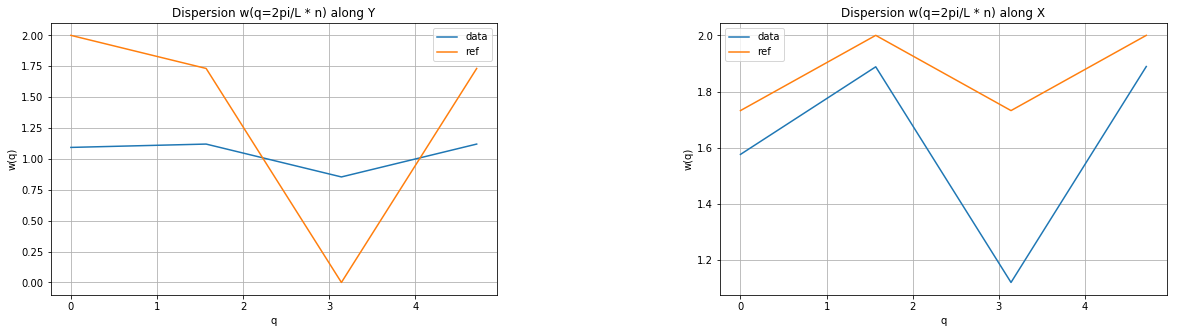

In [27]:
if dim == 2:
    # Get the positions of the highest peak for each q
    disp_w = np.argmax(Sw,axis=0)

    disp_fig, disp_ax = plt.subplots(1,2,gridspec_kw={'wspace':0.5, 'hspace': 0.5}, figsize=(20,5))

    # Plot dispersion along y axis
    x0 = 2
    q_y = np.zeros((Ly))
    for i in range(Ly):
        
        q_y[i] = i + x0 * Lx
        qy = q_y.astype(int)
    print('Values of q printing (along Y):', qy)

    disp_ax[0].set_title('Dispersion w(q=2pi/L * n) along Y')
    disp_ax[0].set_ylabel('w(q)')
    disp_ax[0].set_xlabel('q')
    disp_ax[0].grid()
    disp_ax[0].plot(q[0:4]/Ly*2*pi, disp_w[qy]*delta_w, label="data")
    disp_ax[0].plot(q[0:4]/Ly*2*pi,np.sqrt(4-(np.cos(x0/Lx*2*pi)+np.cos(q[0:4]/Ly*2*pi))**2), label="ref")
    disp_ax[0].legend()
    
    # Plot dispersion along x axis
    y0 = 1
    q_x = np.zeros((Lx))
    for i in range(Lx):
        q_x[i] = Ly * i + y0
        qx = q_x.astype(int)
    print('Values of q printing (along X):', qx)

    disp_ax[1].set_title('Dispersion w(q=2pi/L * n) along X')
    disp_ax[1].set_ylabel('w(q)')
    disp_ax[1].set_xlabel('q')
    disp_ax[1].grid()
    disp_ax[1].plot(q[0:4]/Lx*2*pi, disp_w[qx]*delta_w, label="data")
    disp_ax[1].plot(q[0:4]/Lx*2*pi,np.sqrt(4-(np.cos(q[0:4]/Lx*2*pi)+np.cos(y0/Ly*2*pi))**2), label="ref")
    disp_ax[1].legend()